# **Text Emojifier**

## Setup

In [194]:
import math

from kagglehub import dataset_download
import os
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sb
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Layer, Input
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
from tensorflow.python.keras.callbacks import EarlyStopping

In [195]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [196]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

device='cuda'


### Dataframe

Loading the dataset from kaggle, and preparing the dataframe for the models.
This step includes:
- Unifying emojis that represent the same thing.
- Removing emojis with very few examples.
- Adding columns for processed text, tokenized text, and stemmed text.

In [197]:
def get_emojis_df():
    path = dataset_download("hariharasudhanas/twitter-emoji-prediction")

    dataframes = {}
    for dirpath, dirnames, filenames in os.walk(path):
        if "Train.csv" in filenames:
            csv_path = os.path.join(dirpath, "Train.csv")
            dataframes["Dataset"] = pd.read_csv(csv_path).drop(['Unnamed: 0'], axis = 1)
        if "Mapping.csv" in filenames:
            csv_path = os.path.join(dirpath, "Mapping.csv")
            dataframes["Mapping"] = pd.read_csv(csv_path).drop(['Unnamed: 0'], axis = 1)

    if len(dataframes) != 2:
        raise FileNotFoundError("Some files were not found in the specified directories.")

    return dataframes

In [198]:
def mapping_to_dict(mapping):
    emoticons = mapping['emoticons'].tolist()
    mapp = {}
    for emo in range(0, len(emoticons)):
        mapp[emo]= emoticons[emo]
    return mapp

In [199]:
def load_or_compute_df(file_path, function, *args):
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        return joblib.load(file_path)

    print(f"Computing and saving {file_path}...")
    df = function(*args)
    joblib.dump(df, file_path)
    return df

In [200]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Remove extra white space from text
    # text = re.sub(r'\W', ' ', str(text))          # Remove all the special characters from text
    # text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)   # Remove all single characters from text
    # text = re.sub(r'[^a-zA-Z\s]', '', text)       # Remove any character that isn't alphabetical
    text = text.lower()

    return text

In [201]:
def delete_emoji(df, emoji_number, mapping):
    df.drop(df[df['Label'] == emoji_number].index, inplace=True)
    mapping[emoji_number] = mapping[len(mapping)-1]
    df['Label'] = df['Label'].apply(lambda x: emoji_number if x == len(mapping)-1 else x)
    del mapping[len(mapping)-1]
    return df, mapping

In [202]:
def unify_emojis(df, emojis_numbers, mapping):
    new_label = emojis_numbers[0]
    for emoji_number in emojis_numbers[1:]:
        df['Label'] = df['Label'].apply(lambda x: new_label if x == emoji_number else x)
        del mapping[emoji_number]
    return df, mapping

In [203]:
def fix_missing(df, mapping):
    keys_sorted = [key for key in mapping.keys()]
    print(keys_sorted, type(keys_sorted))
    for i in range(0, len(mapping)):
        if i not in mapping:
            prev_key = keys_sorted.pop()
            df['Label'] = df['Label'].apply(lambda x: i if x == prev_key else x)
            mapping[i] = mapping[prev_key]
            del mapping[prev_key]
    return df, mapping

In [204]:
def encode_df(df):
    df.dropna(inplace=True)

    df['TEXT processed'] = df['TEXT'].apply(process_text)
    df['TEXT tokenized'] = df['TEXT processed'].apply(lambda x: word_tokenize(x))
    df['TEXT stemmed'] = df['TEXT tokenized'].apply(lambda tokens: [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words])
    return df

In [284]:
def get_encoded_dfs():
    """
    Get the encoded dataset with processed, tokenized and stemmed text columns with mapping from labels to emojis.
    """
    dfs = get_emojis_df()

    df = dfs['Dataset']
    mapping = mapping_to_dict(dfs['Mapping'])
    for emoji_num in [19, 12, 11, 9, 8, 5]:  # '❤', '💯', '☀', '🎄', '😘', '🇺🇸'
        df, mapping = delete_emoji(df, emoji_num, mapping)
    df, mapping = unify_emojis(df, [1, 6], mapping)  # '📷', '📸'
    df, mapping = unify_emojis(df, [8, 5, 12], mapping)  # '💙', '💕', '💜'
    df, mapping = unify_emojis(df, [10, 0, 4, 11], mapping)  # '😁', '😜', '😉', '😊'
    df, mapping = unify_emojis(df, [7, 9], mapping)  # '🔥', '😎'

    df, mapping = fix_missing(df, mapping)

    df = encode_df(df)

    return df, mapping

In [285]:
df, emoji_mapping = get_encoded_dfs()
# inverse_emoji_mapping = {v: k for k, v in emoji_mapping.items()}

[1, 2, 3, 7, 8, 10, 13] <class 'list'>


In [322]:
sample = df.sample(5)
sample['emoji'] = sample['Label'].map(lambda x: emoji_mapping[x])
sample

,TEXT,Label,TEXT processed,TEXT tokenized,TEXT stemmed,emoji
43030,"In LOVE with Thor: Ragnarok! Saw it in theaters yesterday &amp; it was super funny, there was lots…\n",2,"in love with thor: ragnarok! saw it in theaters yesterday &amp; it was super funny, there was lots…","[in, love, with, thor, :, ragnarok, !, saw, it, in, theaters, yesterday, &, amp, ;, it, was, super, funny, ,, there, was, lots…]","[love, thor, ragnarok, saw, theater, yesterday, amp, super, funni]",😍
21888,@user @user cosculluelapr @user remix baby musical_ly_followers_free…\n,6,@user @user cosculluelapr @user remix baby musical_ly_followers_free…,"[@, user, @, user, cosculluelapr, @, user, remix, baby, musical_ly_followers_free…]","[user, user, cosculluelapr, user, remix, babi]",🔥
60737,What a BABE thanks for becoming one of my closest friendsss (plus dana) @ Kutztown University…\n,5,what a babe thanks for becoming one of my closest friendsss (plus dana) @ kutztown university…,"[what, a, babe, thanks, for, becoming, one, of, my, closest, friendsss, (, plus, dana, ), @, kutztown, university…]","[babe, thank, becom, one, closest, friendsss, plu, dana, kutztown]",💕
5942,So happy the beautiful weather is back for a second round\n,2,so happy the beautiful weather is back for a second round,"[so, happy, the, beautiful, weather, is, back, for, a, second, round]","[happi, beauti, weather, back, second, round]",😍
44574,regrann from @user - #OmariHardwick vs Fan #ClapBackSeason ( : gettyimages/ Tasos…\n,1,regrann from @user - #omarihardwick vs fan #clapbackseason ( : gettyimages/ tasos…,"[regrann, from, @, user, -, #, omarihardwick, vs, fan, #, clapbackseason, (, :, gettyimages/, tasos…]","[regrann, user, omarihardwick, vs, fan, clapbackseason]",📸


### Train, validation, test splitting

In [295]:
def get_split_df(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=0):
    assert (train_ratio + test_ratio + val_ratio) == 1

    train_df = df.sample(frac=train_ratio, random_state=random_state)
    remaining_df = df.drop(train_df.index)

    validation_df = remaining_df.sample(frac=val_ratio / (val_ratio + test_ratio), random_state=random_state)
    test_df = remaining_df.drop(validation_df.index)

    return train_df, validation_df, test_df

In [208]:
train_df, val_df, test_df = get_split_df(df)

### Bag of Words

Adding bag of words features to the dataframe, which will be used for the softmax model and the simple neural network model.
The bag of words columns are the most popular words in the dataset, and the value of each column is the number of times the word appears in the text.

In [209]:
def get_most_popular_words(df, column, num_words=500):
    print(f"Creating dictionary for {column}...")
    dictionary = {}

    for tokens in df[column]:
        for word in tokens:
                dictionary[word] = dictionary.get(word, 0) + 1

    # Sort and get the top words
    sorted_words = sorted(dictionary.items(), key=lambda item: item[1], reverse=True)
    return [word for word, _ in sorted_words[:num_words]]

In [210]:
top_words = get_most_popular_words(train_df, 'TEXT stemmed')
print(top_words[:15])

Creating dictionary for TEXT stemmed...
['user', 'love', 'new', 'amp', 'day', 'happi', 'thank', 'get', 'time', 'night', 'one', 'today', 'got', 'like', 'york']


In [211]:
def add_bag_of_words(df, column, bag_of_word):
    new_df = df.copy()

    for word in bag_of_word:
        new_df[f'word: {word}'] = new_df[f'{column}'].apply(lambda x: int(x.count(word)))
        new_df[f'word: {word}'] = new_df[f'word: {word}'].astype('float32')
        new_df = new_df.copy()

    return new_df

In [212]:
train_df = load_or_compute_df("train_encoded.joblib", add_bag_of_words, train_df, 'TEXT stemmed', top_words)
val_df = load_or_compute_df("val_encoded.joblib", add_bag_of_words, val_df, 'TEXT stemmed', top_words)
test_df = load_or_compute_df("test_encoded.joblib", add_bag_of_words, test_df, 'TEXT stemmed', top_words)

Loading train_encoded.joblib...
Loading val_encoded.joblib...
Loading test_encoded.joblib...


In [213]:
BOW_FEATURES = [f'word: {word}' for word in top_words]
TARGET = 'Label'

### Model Evaluation

In [214]:
def print_metrics(model_name, y_true, y_pred):
    print(f'/////// {model_name} Evaluation ///////')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f} (weighted)')
    print(f'Recall: {recall:.4f} (weighted)')
    print(f'F1 Score: {f1:.4f} (weighted)')

In [215]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [216]:
def print_model_evaluation(model_name, y_true, y_pred):

    print_metrics(model_name, y_true, y_pred)
    plot_confusion_matrix(y_true, y_pred, emoji_mapping)

    print('\n/////// Detailed Classification Report ///////')
    print(classification_report(y_true, y_pred, digits=4))

### Saving Models

In [217]:
TRAINED_MODELS_FOLDER = 'trained_models'

In [218]:
if not os.path.exists(TRAINED_MODELS_FOLDER):
    os.makedirs(TRAINED_MODELS_FOLDER)

In [219]:
def save_model(model, model_name):
    model_save_path = os.path.join(TRAINED_MODELS_FOLDER, model_name)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

## Data Analysis

In this part we will analyze the dataset, the distribution of the labels, the number of words in each example, and the total number of words in the dataset.

This is an essential step to understand the dataset and the problem we are trying to solve, and to identify any potential issues that may affect the models.

This analysis will help us to:
- Choose the length of the sequences for the LSTM models.
- Understand the distribution of the labels in order to choose the right evaluation metrics.
- Identify any class imbalance that may affect the models.
- Identify any potential issues in the dataset that may affect the models.

In [220]:
print('Number of training examples: ', len(train_df))
print('Number of test examples: ', len(test_df))

Number of training examples:  31396
Number of test examples:  6728


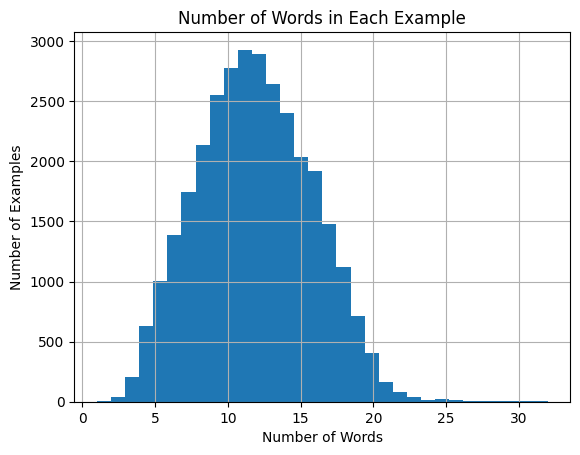

In [221]:
# Histogram of number of words in each example
train_df['TEXT processed'].apply(lambda x: len(x.split())).hist(bins=max(train_df['TEXT processed'].apply(lambda x: len(x.split()))))
plt.xlabel('Number of Words')
plt.ylabel('Number of Examples')
plt.title('Number of Words in Each Example')
plt.show()

In [222]:
# Total number of words in the dataset
total_words = train_df['TEXT tokenized'].apply(lambda x: len(x)).sum()
print('Total number of words in the dataset: ', total_words)

Total number of words in the dataset:  461749


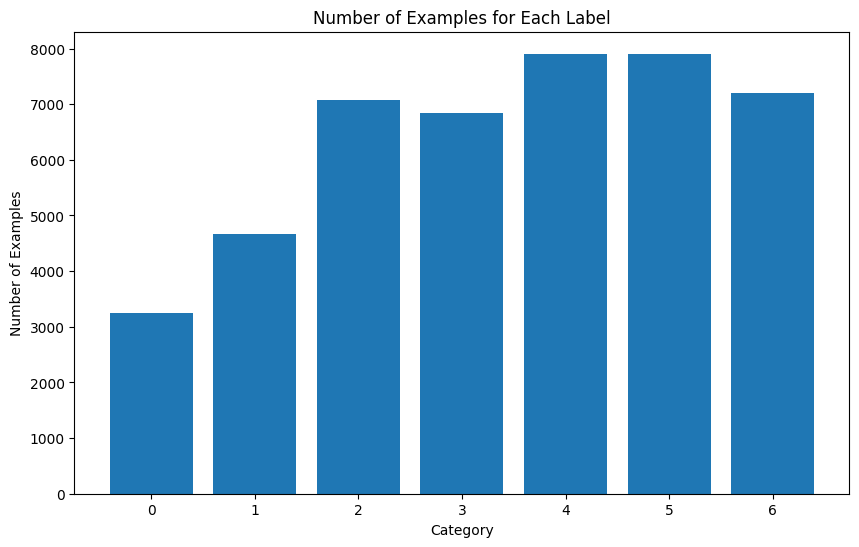

In [223]:
category_counts = df['Label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)

plt.xlabel('Category')
plt.ylabel('Number of Examples')
plt.title('Number of Examples for Each Label')

plt.xticks(ticks=category_counts.index, labels=category_counts.index)
plt.show()

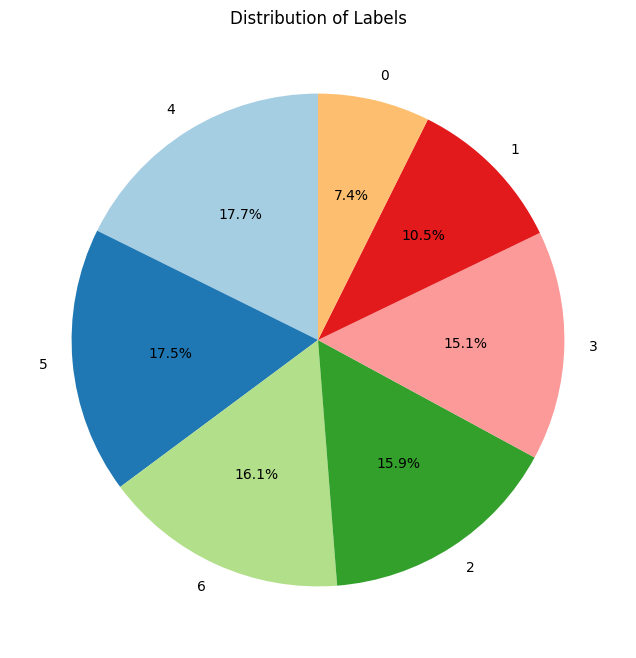

In [224]:
category_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 8))  # Adjust the size of the pie chart
plt.pie(
    category_counts.values,
    labels=category_counts.index, # Optional: Use actual emojis
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors  # Optional: Use a colormap for better visuals
)

plt.title('Distribution of Labels')
plt.show()


In [225]:
emoji_mapping

{1: '📸', 2: '😍', 3: '😂', 0: '✨', 4: '😁', 5: '💕', 6: '🔥'}

## Baseline Model

The baseline model is a dummy classifier that always predicts the most frequent class.

This model will be used as a baseline to compare the performance of the other models and proves that the other models are learning something useful from the data.

In [226]:
baseline_x_train = pd.concat([train_df[BOW_FEATURES], val_df[BOW_FEATURES]], axis=0)
baseline_y_train = pd.concat([train_df[TARGET], val_df[TARGET]])

baseline_x_test = test_df[BOW_FEATURES]
baseline_y_test = test_df[TARGET]

In [227]:
baseline_model = DummyClassifier(strategy='most_frequent')

In [228]:
print('Training baseline model...')
baseline_model.fit(baseline_x_train, baseline_y_train)

Training baseline model...


DummyClassifier(strategy='most_frequent')

In [229]:
print('Predicting with baseline model...')
baseline_y_pred = baseline_model.predict(baseline_x_test)

Predicting with baseline model...


/////// Baseline Model Evaluation ///////
Accuracy: 0.1758
Precision: 0.0309 (weighted)
Recall: 0.1758 (weighted)
F1 Score: 0.0526 (weighted)


C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


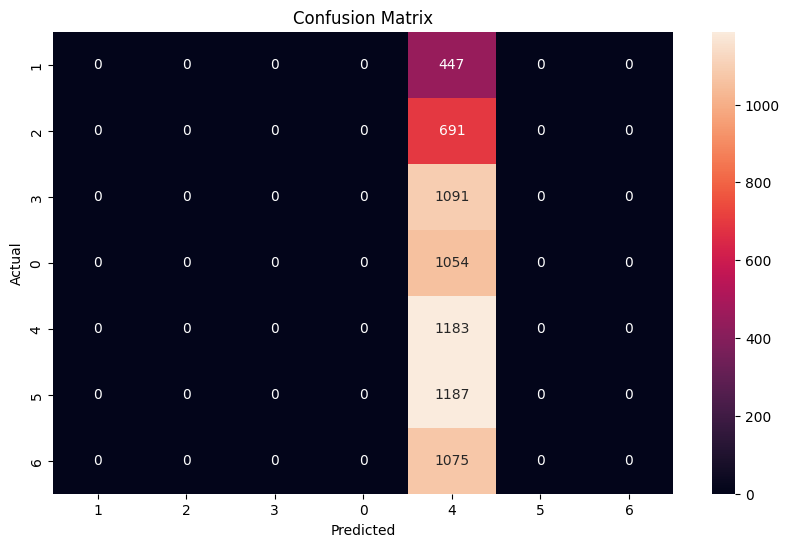


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       447
           1     0.0000    0.0000    0.0000       691
           2     0.0000    0.0000    0.0000      1091
           3     0.0000    0.0000    0.0000      1054
           4     0.1758    1.0000    0.2991      1183
           5     0.0000    0.0000    0.0000      1187
           6     0.0000    0.0000    0.0000      1075

    accuracy                         0.1758      6728
   macro avg     0.0251    0.1429    0.0427      6728
weighted avg     0.0309    0.1758    0.0526      6728



C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [230]:
print_model_evaluation('Baseline Model', baseline_y_test, baseline_y_pred)

## Softmax Model

The softmax model uses the 200 top words from the bag of words features to predict the emoji label.

This model is a simple linear model that uses the softmax function to predict the probabilities of each class.

In [231]:
softmax_x_train = torch.tensor(train_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_train = torch.tensor(train_df[TARGET].values, dtype=torch.float32)

softmax_x_val = torch.tensor(val_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_val = torch.tensor(val_df[TARGET].values, dtype=torch.float32)

softmax_x_test = torch.tensor(test_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_test = torch.tensor(test_df[TARGET].values, dtype=torch.float32)

In [232]:
class SoftmaxModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftmaxModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x) # Softmax is included in the loss function

In [233]:
# Model configuration
num_classes = len(emoji_mapping)
input_dim = softmax_x_train.shape[1]
softmax_model = SoftmaxModel(input_dim, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(softmax_model.parameters(), lr=0.01)

In [234]:
# Early Stopping Configuration
patience = 10
min_delta = 1e-4
best_val_loss = float('inf')
early_stop_counter = 0

In [235]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    softmax_model.train()

    # Forward pass
    outputs = softmax_model(softmax_x_train)
    loss = criterion(outputs, softmax_y_train.long())  # Ensure labels are integers

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    softmax_model.eval()
    with torch.no_grad():
        val_outputs = softmax_model(softmax_x_val)
        val_loss = criterion(val_outputs, softmax_y_val.long())

    val_losses.append(val_loss.item())

    # Check for early stopping
    if val_loss.item() < best_val_loss - min_delta:
        best_val_loss = val_loss.item()
        early_stop_counter = 0
        torch.save(softmax_model.state_dict(), 'best_softmax_model.pth')
    else:
        early_stop_counter += 1

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
softmax_model.load_state_dict(torch.load('best_softmax_model.pth'))
os.remove('best_softmax_model.pth')

Epoch [50/200], Train Loss: 1.7399, Val Loss: 1.7593
Epoch [100/200], Train Loss: 1.7134, Val Loss: 1.7399
Epoch [150/200], Train Loss: 1.7073, Val Loss: 1.7369
Early stopping triggered at epoch 184. Best validation loss: 1.7365


C:\Users\Chaim\AppData\Local\Temp\ipykernel_27832\2439864243.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  softmax_model.load_state_dict(torch.load('best_softmax_mode

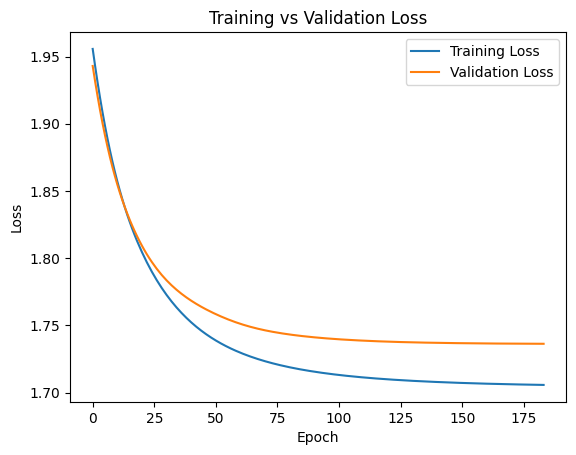

In [236]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

/////// Softmax Model Evaluation ///////
Accuracy: 0.3132
Precision: 0.3132 (weighted)
Recall: 0.3132 (weighted)
F1 Score: 0.3040 (weighted)


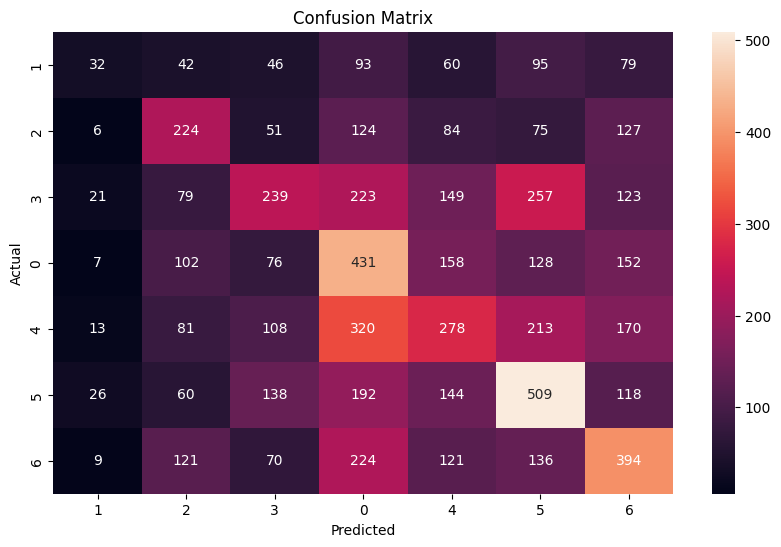


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

         0.0     0.2807    0.0716    0.1141       447
         1.0     0.3159    0.3242    0.3200       691
         2.0     0.3283    0.2191    0.2628      1091
         3.0     0.2682    0.4089    0.3239      1054
         4.0     0.2797    0.2350    0.2554      1183
         5.0     0.3602    0.4288    0.3915      1187
         6.0     0.3388    0.3665    0.3521      1075

    accuracy                         0.3132      6728
   macro avg     0.3103    0.2934    0.2885      6728
weighted avg     0.3132    0.3132    0.3040      6728



In [237]:
softmax_model.eval()
with torch.no_grad():
    test_outputs = softmax_model(softmax_x_test)
    softmax_y_pred = torch.argmax(test_outputs, dim=1)
print_model_evaluation('Softmax Model', softmax_y_test, softmax_y_pred)

In [238]:
save_model(softmax_model, 'softmax_model.pth')

Model saved to trained_models\softmax_model.pth


## Basic Neural Network

The simple neural network model uses the bag of words features to predict the emoji label. The model consists of fully connected layers with ReLU activation functions, batch normalization and dropout layers to prevent overfitting.

In [239]:
train_dataset = TensorDataset(torch.tensor(train_df[BOW_FEATURES].values, dtype=torch.float32),
                               torch.tensor(train_df[TARGET].values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_df[BOW_FEATURES].values, dtype=torch.float32),
                             torch.tensor(val_df[TARGET].values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_df[BOW_FEATURES].values, dtype=torch.float32),
                              torch.tensor(test_df[TARGET].values, dtype=torch.float32))

In [240]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

In [241]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, output_size)  # No activation, raw logits for CrossEntropyLoss
        )

    def forward(self, x):
        return self.network(x)

In [242]:
# Model configuration
num_classes = len(emoji_mapping)
input_dim = train_df[BOW_FEATURES].shape[1]
simple_nn_model = SimpleNN(input_dim, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_nn_model.parameters(), lr=0.001, weight_decay=1e-4)

In [243]:
# Early Stopping Configuration
patience = 10
min_delta = 1e-4
best_val_loss = float('inf')
early_stop_counter = 0

In [244]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    simple_nn_model.train()
    running_train_loss = 0.0  # Accumulate training loss
    for inputs, targets in train_loader:
        # Forward pass
        outputs = simple_nn_model(inputs)
        loss = criterion(outputs, targets.long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    simple_nn_model.eval()
    running_val_loss = 0.0  # Accumulate validation loss
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = simple_nn_model(val_inputs)
            val_loss = criterion(val_outputs, val_targets.long())
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(simple_nn_model.state_dict(), 'best_simple_nn_model.pth')
    else:
        early_stop_counter += 1

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
simple_nn_model.load_state_dict(torch.load('best_simple_nn_model.pth'))
os.remove('best_simple_nn_model.pth')

Epoch [1/50], Train Loss: 1.8351, Val Loss: 1.7377
Epoch [2/50], Train Loss: 1.7463, Val Loss: 1.7105
Epoch [3/50], Train Loss: 1.7180, Val Loss: 1.7049
Epoch [4/50], Train Loss: 1.6990, Val Loss: 1.7032
Epoch [5/50], Train Loss: 1.6825, Val Loss: 1.6892
Epoch [6/50], Train Loss: 1.6766, Val Loss: 1.6933
Epoch [7/50], Train Loss: 1.6637, Val Loss: 1.6963
Epoch [8/50], Train Loss: 1.6601, Val Loss: 1.6986
Epoch [9/50], Train Loss: 1.6484, Val Loss: 1.6933
Epoch [10/50], Train Loss: 1.6425, Val Loss: 1.6952
Epoch [11/50], Train Loss: 1.6396, Val Loss: 1.6955
Epoch [12/50], Train Loss: 1.6303, Val Loss: 1.6948
Epoch [13/50], Train Loss: 1.6223, Val Loss: 1.6989
Epoch [14/50], Train Loss: 1.6165, Val Loss: 1.6982
Epoch [15/50], Train Loss: 1.6182, Val Loss: 1.6956
Early stopping triggered at epoch 15. Best validation loss: 1.6892


C:\Users\Chaim\AppData\Local\Temp\ipykernel_27832\4287012924.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_nn_model.load_state_dict(torch.load('best_simple_nn_

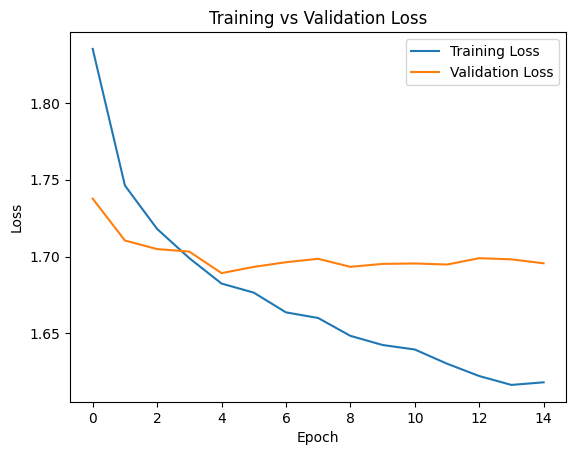

In [245]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

/////// SimpleNN Model Evaluation ///////
Accuracy: 0.3387
Precision: 0.3376 (weighted)
Recall: 0.3387 (weighted)
F1 Score: 0.3276 (weighted)


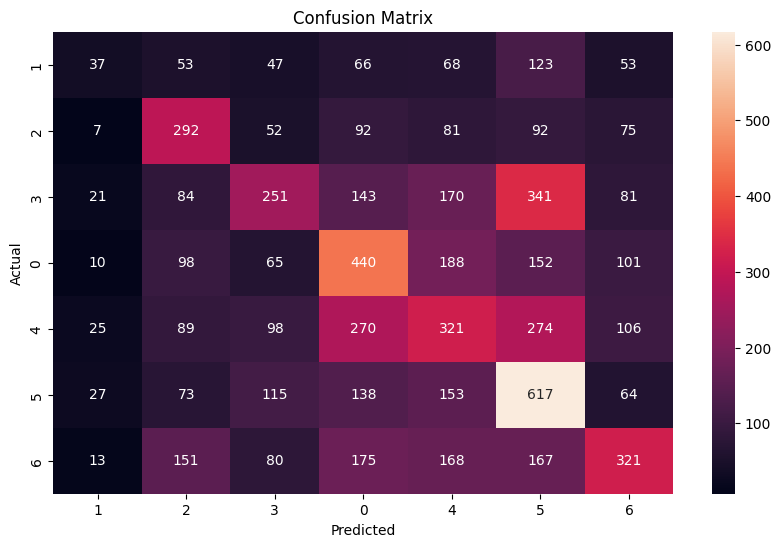


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.2643    0.0828    0.1261       447
           1     0.3476    0.4226    0.3815       691
           2     0.3545    0.2301    0.2790      1091
           3     0.3323    0.4175    0.3701      1054
           4     0.2794    0.2713    0.2753      1183
           5     0.3494    0.5198    0.4179      1187
           6     0.4007    0.2986    0.3422      1075

    accuracy                         0.3387      6728
   macro avg     0.3326    0.3204    0.3131      6728
weighted avg     0.3376    0.3387    0.3276      6728



In [246]:
simple_nn_model.eval()
all_preds = []

with torch.no_grad():
    for test_inputs, _ in test_loader:  # Use test_loader for batch processing
        test_outputs = simple_nn_model(test_inputs)
        batch_preds = torch.argmax(test_outputs, dim=1)
        all_preds.append(batch_preds)
simple_nn_y_pred = torch.cat(all_preds)

print_model_evaluation('SimpleNN Model', test_df[TARGET].values, simple_nn_y_pred.cpu().numpy())

In [247]:
save_model(simple_nn_model, 'simple_nn_model.pth')

Model saved to trained_models\simple_nn_model.pth


## LSTM with Embeddings

In this part, we will use a bidirectional LSTM neural network with pre-trained GloVe embeddings to predict the emoji label.

### Word Embeddings

We used the 200-dimensional GloVe embeddings trained on [Twitter data](https://nlp.stanford.edu/data/glove.twitter.27B.zip) (since our dataset is from Twitter).


In [248]:
f = open("glove.twitter.27B/glove.twitter.27B.200d.txt", encoding='utf8')
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    emb = np.array(values[1:], dtype='float')
    embedding_index[word] = emb
embedding_dim = embedding_index['hello'].shape[0]

In [249]:
embedding_index['user']

array([ 4.2766e-01,  2.4532e-01, -8.4922e-01,  3.1648e-01,  1.6538e-01,
       -5.8628e-01,  8.5115e-01,  6.3838e-03,  6.5366e-02, -7.1155e-01,
       -2.2464e-01, -1.3552e-01, -1.5848e-01, -1.0465e+00, -2.5073e-01,
       -3.2956e-01,  5.8865e-01,  7.2249e-02,  1.4451e-01, -1.7732e-01,
       -1.0752e-03,  1.0197e-01,  7.3183e-02,  3.2360e-01, -8.7387e-01,
       -1.0808e+00,  3.3931e-01, -1.1672e-01,  1.0462e-01,  1.0419e+00,
        3.6597e-01,  2.0681e-02,  1.3460e-01, -9.4696e-01, -2.3978e-02,
       -8.2389e-01,  9.6535e-02, -1.3870e-01, -5.2832e-01,  3.9776e-01,
       -8.4624e-01,  4.7066e-01, -2.5022e-01,  7.7712e-01, -4.3216e-01,
        6.6454e-02, -3.5458e-01, -4.9915e-01,  2.3011e-01,  1.0778e-01,
       -1.4022e-01,  5.0438e-01, -5.8577e-01, -2.7001e-01,  1.9374e-01,
        4.2087e-01,  1.4654e-02,  1.0986e+00, -8.2837e-01, -8.0830e-01,
        1.5268e-02, -7.7748e-01,  8.1273e-01,  3.4014e-01,  3.3876e-01,
        5.4724e-02,  2.0892e-01,  3.0737e-01,  1.4706e-01,  4.24

In [250]:
def get_embedding_output(X_tokenized, embedding_dim, max_sequence_len=20, padding_value=0.0):
    """
    Convert tokenized text data into embedding vectors with padding.

    Args:
    X_tokenized (list of lists): Tokenized text, where each sample is a list of tokens.
    max_sequence_len (int): Maximum number of tokens per sequence.
    padding_value (float): Value to use for padding shorter sequences.

    Returns:
    np.ndarray: Array of shape (num_samples, max_sequence_len, embedding_dim=50).
    """
    embedding_output = np.full((len(X_tokenized), max_sequence_len, embedding_dim), padding_value, dtype=np.float32)

    for ix, tokens in enumerate(X_tokenized):
        for ij, token in enumerate(tokens[:max_sequence_len]):
            embedding_vector = embedding_index.get(token.lower())
            if embedding_vector is not None:
                embedding_output[ix][ij] = embedding_vector

    return embedding_output

In [251]:
max_sequence_len = 20
x_embed = get_embedding_output(df['TEXT tokenized'], embedding_dim, max_sequence_len)
y_one_hot = keras.utils.to_categorical(df[TARGET])

In [252]:
print(f"{x_embed.shape=}, {y_one_hot.shape=}")

x_embed.shape=(44852, 20, 200), y_one_hot.shape=(44852, 7)


In [253]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_embed, y_one_hot, test_size=0.2)

### Model

The LSTM model consists of an embedding layer, a bidirectional LSTM layer, and a dense output layer with a softmax activation function. We also added dropout layers to prevent overfitting.

In [254]:
model = Sequential()
model.add(Input(shape=(max_sequence_len, embedding_dim)))
model.add(Bidirectional(LSTM(units=512)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=len(emoji_mapping), activation='softmax'))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ (None, 1024)                │       2,920,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,062,215 (11.68 MB)

 Trainable params: 3,062,215 (11.68 MB)

 Non-trainable params: 0 (0.00 B)

In [255]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [256]:
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=64, epochs=10,
                 callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.2817 - loss: 1.7690 - val_accuracy: 0.3977 - val_loss: 1.5575
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 131ms/step - accuracy: 0.4254 - loss: 1.5161 - val_accuracy: 0.4269 - val_loss: 1.4883
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.4648 - loss: 1.4140 - val_accuracy: 0.4413 - val_loss: 1.4748
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accuracy: 0.5019 - loss: 1.3254 - val_accuracy: 0.4349 - val_loss: 1.4754
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - accuracy: 0.5356 - loss: 1.2367 - val_accuracy: 0.4400 - val_loss: 1.4992
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 60s 134ms/step - accuracy: 0.5917 - loss: 1.0828 - val_accuracy: 0.4276 - val_loss: 1.5871


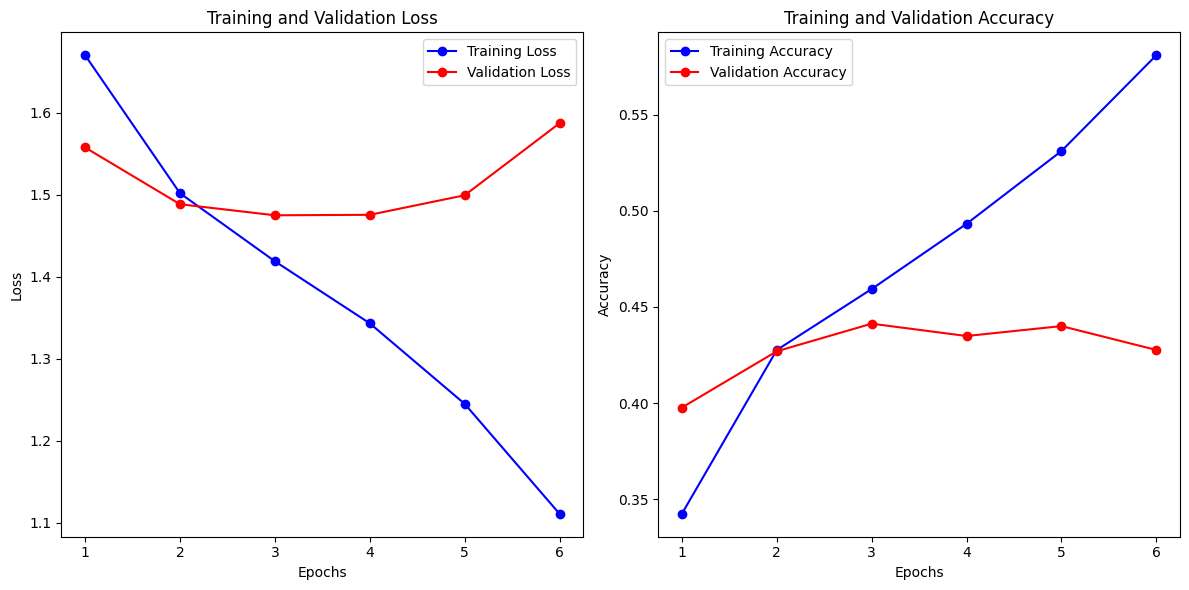

In [257]:
history = hist.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create epochs array
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [258]:
model.evaluate(x_test, y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4388 - loss: 1.4786


[1.478278636932373, 0.44331735372543335]

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
/////// Bidirectional LSTM Model Evaluation ///////
Accuracy: 0.4433
Precision: 0.4488 (weighted)
Recall: 0.4433 (weighted)
F1 Score: 0.4373 (weighted)


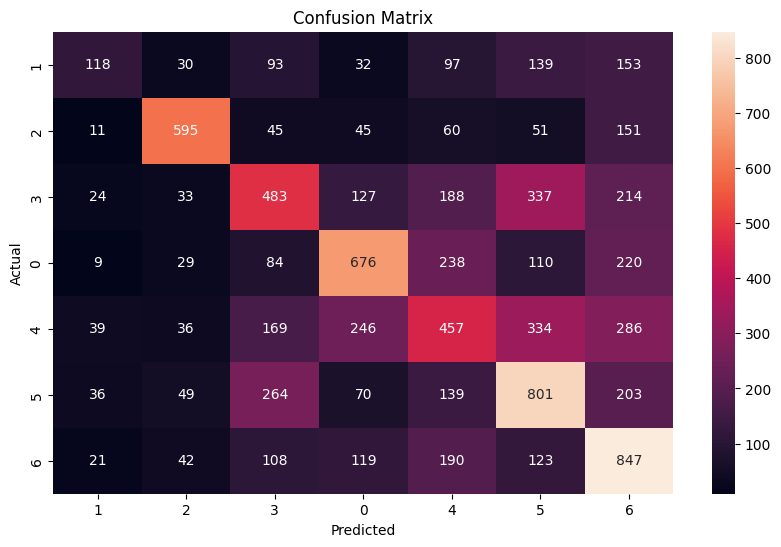


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.4574    0.1782    0.2565       662
           1     0.7310    0.6211    0.6716       958
           2     0.3876    0.3435    0.3643      1406
           3     0.5141    0.4949    0.5043      1366
           4     0.3338    0.2916    0.3113      1567
           5     0.4227    0.5128    0.4634      1562
           6     0.4084    0.5841    0.4807      1450

    accuracy                         0.4433      8971
   macro avg     0.4650    0.4323    0.4360      8971
weighted avg     0.4488    0.4433    0.4373      8971



In [259]:
# Make predictions on the test set
y_pred_proba = model.predict(x_test)  # Predict probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices

# Convert true labels to class indices if they are one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Print evaluation results
print_model_evaluation('Bidirectional LSTM Model', y_true, y_pred)


In [260]:
model.save('trained_models/lstm_model.keras')

### Attention and Self-Attention

We will add attention and self-attention layers to the LSTM model to improve its performance. The attention layer will help the model focus on the most relevant parts of the input sequence, while the self-attention layer will help the model learn the relationships between different parts of the input sequence.


In [261]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weights',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Score computation
        e = K.tanh(K.dot(x, self.W) + self.b)
        # Convert scores to probabilities
        alpha = K.softmax(e, axis=1)
        # Context vector as weighted sum of input sequences
        context = K.sum(alpha * x, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [268]:
model = Sequential()
model.add(Input(shape=(max_sequence_len, embedding_dim)))
model.add(Bidirectional(LSTM(units=512, recurrent_dropout=0.3, return_sequences=True)))
model.add(SeqSelfAttention())
model.add(Bidirectional(LSTM(units=256, recurrent_dropout=0.3, return_sequences=True)))
model.add(Attention())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=len(emoji_mapping), activation='softmax'))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_15 (Bidirectional)     │ (None, 20, 1024)            │       2,920,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ seq_self_attention_4                 │ (None, 20, 1024)            │          65,601 │
│ (SeqSelfAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 20, 512)             │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_3 (Attention)              │ (None, 512)                 │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,686,281 (21.69 MB)

 Trainable params: 5,686,281 (21.69 MB)

 Non-trainable params: 0 (0.00 B)

In [269]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [270]:
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=256, epochs=15,
                 callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 105s 845ms/step - accuracy: 0.2286 - loss: 1.8542 - val_accuracy: 0.3669 - val_loss: 1.6155
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 94s 830ms/step - accuracy: 0.3753 - loss: 1.6112 - val_accuracy: 0.4081 - val_loss: 1.5429
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 834ms/step - accuracy: 0.4176 - loss: 1.5335 - val_accuracy: 0.4243 - val_loss: 1.5097
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 94s 836ms/step - accuracy: 0.4339 - loss: 1.4835 - val_accuracy: 0.4324 - val_loss: 1.4885
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 832ms/step - accuracy: 0.4592 - loss: 1.4439 - val_accuracy: 0.4376 - val_loss: 1.4814
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 95s 838ms/step - accuracy: 0.4743 - loss: 1.3935 - val_accuracy: 0.4375 - val_loss: 1.4894
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 95s 837ms/step - accuracy: 0.4882 - loss: 1.3606 - val_accuracy: 0.4417 - val_loss: 1.4897
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 95s 838ms/step - accuracy: 0.5115 - loss

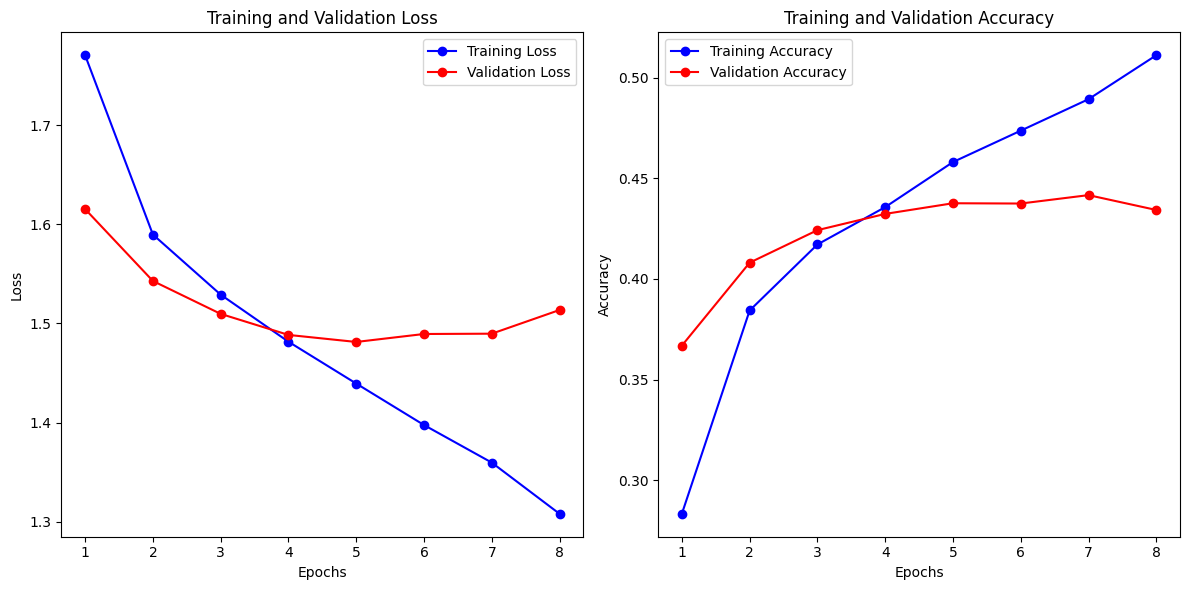

In [272]:
history = hist.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create epochs array
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [273]:
model.evaluate(x_test, y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.4363 - loss: 1.4785


[1.4813858270645142, 0.43807825446128845]

281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step
/////// Bidirectional LSTM Attention Model Evaluation ///////
Accuracy: 0.4381
Precision: 0.4523 (weighted)
Recall: 0.4381 (weighted)
F1 Score: 0.4290 (weighted)


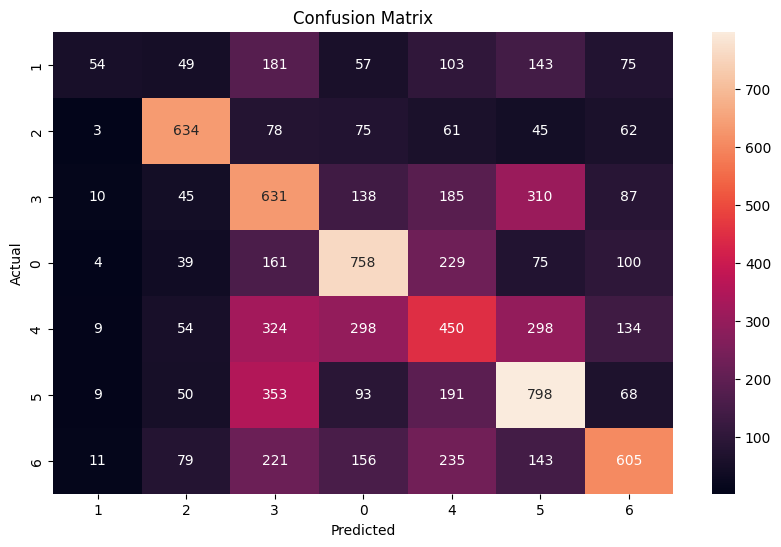


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.5400    0.0816    0.1417       662
           1     0.6674    0.6618    0.6646       958
           2     0.3238    0.4488    0.3762      1406
           3     0.4813    0.5549    0.5155      1366
           4     0.3095    0.2872    0.2979      1567
           5     0.4404    0.5109    0.4730      1562
           6     0.5349    0.4172    0.4688      1450

    accuracy                         0.4381      8971
   macro avg     0.4710    0.4232    0.4197      8971
weighted avg     0.4523    0.4381    0.4290      8971



In [274]:
# Make predictions on the test set
y_pred_proba = model.predict(x_test)  # Predict probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices

# Convert true labels to class indices if they are one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Print evaluation results
print_model_evaluation('Bidirectional LSTM Attention Model', y_true, y_pred)

In [275]:
model.save('trained_models/lstm_model_attention.keras')

## Conclusion

In this notebook, we built and evaluated several models to predict emojis from text data. We started by preprocessing the dataset, encoding the labels, and adding bag of words features. We then trained and evaluated a baseline model, a softmax model, a simple neural network, and a bidirectional LSTM model with pre-trained GloVe embeddings.

| Metric               | Baseline | Softmax | FCNN  | LSTM RNN | LSTM RNN + Attention |
|----------------------|----------|---------|-------|----------|----------------------|
| Accuracy             | 0.1758   | 0.3133  | 0.3352 | 0.4390   | 0.4387               |
| Precision (weighted) | 0.0309   | 0.3139  | 0.3313 | 0.4369   | 0.4459               |
| Recall (weighted)    | 0.1758   | 0.3133  | 0.3352 | 0.4390   | 0.4387               |
| F1 Score (weighted)  | 0.0526   | 0.3043  | 0.3254 | 0.4288   | 0.4309               |


The most considerable improvement occurred when we used the LSTM model with pre-trained GloVe embeddings, which achieved an F1-score of 0.4288. Adding attention to the LSTM model did not improve the performance significantly. Our assumption for that is the short length of the sentences in the dataset, which may not require the model to focus on specific parts of the input sequence and the bidirectional LSTM layer already captures the context from both directions.

Considering the hardships of the dataset, including the different usages of different people for emojis and the variety of emojis that fit a single sentence, the models' performance is more than satisfactory, and we will see the results in the examples below.

## Examples

In [276]:
from tensorflow.keras.models import load_model

model = load_model('trained_models/lstm_model_attention.keras', custom_objects={'Attention': Attention})

In [277]:
print(emoji_mapping)

{1: '📸', 2: '😍', 3: '😂', 0: '✨', 4: '😁', 5: '💕', 6: '🔥'}


In [278]:
examples = [
    'I had an amazing weekend with my friends',
    'My vacation is coming up soon',
    'Yoav had a great time at the party',
    'I cannot believe this had just happened',
    'Magic is in the air',
    'I had a lovely time around the city, such great scenes',
    'I am so excited for the concert tonight',
    'The birthday party was a blast',
]

In [279]:
def tokenize_examples(examples):
    processed = [process_text(example) for example in examples]
    tokenized = [word_tokenize(example) for example in processed]
    return tokenized

tokenized_examples = tokenize_examples(examples)

In [ ]:
x_examples = get_embedding_output(tokenized_examples, embedding_dim, max_sequence_len)

# Predict
predictions = model.predict(x_examples)
predicted_classes = predictions.argmax(axis=1)

# Map predicted classes to emojis (assuming emoji_mapping is a dictionary)
predicted_emojis = [emoji_mapping[class_idx] for class_idx in predicted_classes]

# Display examples and predictions
for example, emoji in zip(examples, predicted_emojis):
    print(f"Example: {example}")
    print(f"Predicted Emoji: {emoji}")
    print("-" * 40)

The model predicted fitting emojis for the statements.

The most noteable predictions are:
- "I cannot believe this had just happened" -> 😂

This example shows the model's abilty to understand suprise and humor in a sentence without relying on keywords.

- "I had a lovely time around the city, such great scenes" -> 📸

Despite having the word 'lovely', which indicates hearts emoji, the model predicted the camera emoji, which is more fitting for the sentence.